# Dyad Position Predictor
Train a neural network to predict dyad positions on a per-position basis from encoded DNA sequences (0-7).

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
from pathlib import Path

from ChromatinFibers import simulate_chromatin_fibers, SimulationParams, SequencePlotter

In [ ]:
# Define simulation parameters and filename
simulation_params = SimulationParams(n_samples=10)

print("Simulation parameters:")
for key, value in simulation_params.__dict__.items():
    print(f"  {key}: {value}")

filename = rf"data/LLM models/dyad_predictor {simulation_params.n_samples}_{simulation_params.length_bp}.pt"
plotter = SequencePlotter()

Simulation parameters:
  n_samples: 10
  length_bp: 10000
  amplitude: 0.05
  period_bp: 10.0
  chemical_potential_kT: 0.0
  e_contact_kT: -0.5
  motifs: ('A',)
  strand: both
  efficiency: 0.7
  steric_exclusion_bp: 0


In [ ]:
# Generate data if filename does not exist
data_filename = filename.replace(".pt", ".npz")
if Path(data_filename).exists() is False:
    dyad_positions, _, encoded_seq = simulate_chromatin_fibers(simulation_params)

    np.savez_compressed(
        data_filename,
        dyad_positions=np.array(dyad_positions, dtype=object),
        encoded_seq=np.array(encoded_seq, dtype=object),
    )

    # Write/merge simulation parameters into a unified config JSON
    config_path = Path(filename).with_suffix(".json")
    if config_path.exists():
        with open(config_path, "r") as f:
            existing_config = json.load(f)
    else:
        existing_config = {}

    existing_config["simulation"] = simulation_params.__dict__

    with open(config_path, "w") as f:
        json.dump(existing_config, f, indent=4)

    print("Data saved:", data_filename)
    print("Simulation parameters written to:", config_path)
else:
    print("Data already exists, skipping simulation.")
    data = np.load(data_filename, allow_pickle=True)
    dyad_positions = data["dyad_positions"]
    encoded_seq = data["encoded_seq"]

100%|██████████| 10/10 [01:03<00:00,  6.34s/it]

Data saved: data/LLM models/dyad_predictor 10_10000.npz
Simulation parameters written to: data/LLM models/dyad_predictor 10_10000.json


## Step 1: Define the Model Architecture

In [ ]:
class DyadPredictor(nn.Module):
    """Per-position dyad predictor using Conv1d and bidirectional context."""

    def __init__(
        self, vocab_size=8, embedding_dim=16, hidden_dim=64, num_layers=2, dropout=0.3
    ):
        super().__init__()
        self.vocab_size = vocab_size

        # Embedding layer (map 0-7 to dense vectors)
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # Conv blocks for local context
        self.conv1 = nn.Conv1d(embedding_dim, hidden_dim, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)

        # BiLSTM for global context
        self.lstm = nn.LSTM(
            hidden_dim,
            hidden_dim // 2,
            num_layers=num_layers,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True,
        )

        # Output head
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1),
        )

    def forward(self, x):
        """Forward pass.
        Args:
            x: (batch_size, seq_len) - encoded sequence
        Returns:
            logits: (batch_size, seq_len, 1) - per-position dyad logits
        """
        # Embedding: (batch, seq_len) -> (batch, seq_len, embed_dim)
        x = self.embedding(x)

        # Conv blocks: (batch, seq_len, embed_dim) -> (batch, embed_dim, seq_len)
        x = x.transpose(1, 2)
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.relu(x)

        # Back to (batch, seq_len, hidden_dim)
        x = x.transpose(1, 2)

        # LSTM: (batch, seq_len, hidden_dim) -> (batch, seq_len, hidden_dim)
        x, _ = self.lstm(x)

        # Per-position classification: (batch, seq_len, hidden_dim) -> (batch, seq_len, 1)
        logits = self.fc(x)

        return logits

## Step 2: Define Custom Dataset

In [ ]:
class DyadDataset(Dataset):
    """Memory-mapped dataset for dyad position prediction - loads data on-demand from disk."""

    def __init__(self, data_filename, indices=None, max_seq_len=None):
        """
        Args:
            data_filename: path to .npz file containing dyad_positions and encoded_seq
            indices: list of sample indices to use (for train/val/test split)
            max_seq_len: optional, pad/truncate sequences to this length
        """
        self.data_filename = data_filename
        self.indices = indices

        # Load metadata only (not actual arrays) to determine dataset size and max_seq_len
        with np.load(data_filename, allow_pickle=True, mmap_mode="r") as data:
            self.n_total_samples = len(data["dyad_positions"])

            # Compute max_seq_len if not provided
            if max_seq_len is None:
                if indices is not None:
                    # Only check sequences we'll actually use
                    self.max_seq_len = max(len(data["encoded_seq"][i]) for i in indices)
                else:
                    # Check all sequences
                    self.max_seq_len = max(len(seq) for seq in data["encoded_seq"])
            else:
                self.max_seq_len = max_seq_len

        # Default to all samples if no indices provided
        if self.indices is None:
            self.indices = list(range(self.n_total_samples))

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        # Map dataset index to actual file index
        real_idx = self.indices[idx]

        # Load only the requested sample from disk (memory-mapped)
        with np.load(self.data_filename, allow_pickle=True, mmap_mode="r") as data:
            dyad_pos = data["dyad_positions"][real_idx]
            encoded_seq = data["encoded_seq"][real_idx]

        # Convert to regular numpy arrays (handle object array wrapping)
        dyad_pos = np.asarray(dyad_pos, dtype=np.int64)
        encoded_seq = np.asarray(encoded_seq, dtype=np.int64)

        seq_len = len(encoded_seq)

        # Create binary label: 1 if dyad at position, 0 otherwise
        label = np.zeros(seq_len, dtype=np.float32)
        for pos in dyad_pos:
            if 0 <= pos < seq_len:
                label[pos] = 1.0

        # Convert to tensors
        seq_tensor = torch.LongTensor(encoded_seq)
        label_tensor = torch.FloatTensor(label)

        # Pad/truncate to max_seq_len
        if seq_len < self.max_seq_len:
            pad_len = self.max_seq_len - seq_len
            seq_tensor = torch.nn.functional.pad(seq_tensor, (0, pad_len), value=0)
            label_tensor = torch.nn.functional.pad(
                label_tensor, (0, pad_len), value=-1
            )  # -1 for padding
        elif seq_len > self.max_seq_len:
            seq_tensor = seq_tensor[: self.max_seq_len]
            label_tensor = label_tensor[: self.max_seq_len]

        return seq_tensor, label_tensor

## Step 3: Load Your Data
Replace this with your actual data loading logic.

In [ ]:
# Create train/val/test split using indices (no data loaded into memory yet)
# This approach scales to arbitrarily large datasets

# Get total number of samples from the data file
with np.load(data_filename, allow_pickle=True, mmap_mode="r") as data:
    n_total = len(data["dyad_positions"])

# Split indices for train/val/test
n_train = int(0.7 * n_total)
n_val = int(0.15 * n_total)

train_indices = list(range(n_train))
val_indices = list(range(n_train, n_train + n_val))
test_indices = list(range(n_train + n_val, n_total))

print(
    f"Dataset split - Train: {len(train_indices)}, Val: {len(val_indices)}, Test: {len(test_indices)}"
)
print(f"Total samples: {n_total}")
print(f"Memory-mapped mode: Data will be loaded on-demand during training")

Dataset split - Train: 7, Val: 1, Test: 2
Total samples: 10
Memory-mapped mode: Data will be loaded on-demand during training


## Step 4: Create DataLoaders

In [ ]:
# Create memory-mapped datasets (data loaded on-demand, not held in RAM)
train_dataset = DyadDataset(data_filename, indices=train_indices)
val_dataset = DyadDataset(
    data_filename, indices=val_indices, max_seq_len=train_dataset.max_seq_len
)
test_dataset = DyadDataset(
    data_filename, indices=test_indices, max_seq_len=train_dataset.max_seq_len
)

batch_size = 32

# Enable multi-processing to parallelize disk I/O
# Set num_workers=0 if you get errors (Windows compatibility issue)
# Set num_workers=2-4 for best performance on Linux/Mac
num_workers = 2  # Adjust based on your CPU cores

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    persistent_workers=True if num_workers > 0 else False,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    persistent_workers=True if num_workers > 0 else False,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    persistent_workers=True if num_workers > 0 else False,
)

print(f"Max sequence length: {train_dataset.max_seq_len}")
print(
    f"DataLoaders created: train={len(train_loader)} batches, val={len(val_loader)}, test={len(test_loader)}"
)
print(f"Using {num_workers} worker processes for data loading")
print(f"Memory footprint: Minimal (data loaded on-demand)")

Max sequence length: 10000
DataLoaders created: train=1 batches, val=1, test=1
Using 2 worker processes for data loading
Memory footprint: Minimal (data loaded on-demand)


## Step 5: Initialize Model and Training Components

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = DyadPredictor(
    vocab_size=8, embedding_dim=16, hidden_dim=64, num_layers=2, dropout=0.3
)
model = model.to(device)

# Loss function: BCEWithLogitsLoss (combines sigmoid + BCE)
pos_weight = torch.tensor([10.0]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight, reduction="none")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
# ReduceLROnPlateau without 'verbose' for compatibility with older PyTorch versions
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=3
)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Using device: cpu
Model parameters: 78,401
Model parameters: 78,401


In [ ]:
# Compute a pos_weight from training data (ignore padding where label == -1)


def compute_pos_weight_from_dataset(dataset):
    pos = 0
    neg = 0
    for seq_tensor, label_tensor in dataset:
        arr = np.asarray(label_tensor)
        mask = arr >= 0  # only count real positions, not padding (-1)
        if mask.sum() == 0:
            continue
        pos += int((arr[mask] == 1).sum())
        neg += int((arr[mask] == 0).sum())
    # Avoid division by zero
    if pos == 0:
        print(
            "Warning: no positive examples found in train_dataset; setting pos=1 to avoid division by zero"
        )
        pos = 1
    # pos_weight used by BCEWithLogitsLoss scales the positive class loss: pos_weight = neg/pos
    pw = float(neg) / float(pos)
    return torch.tensor([pw], dtype=torch.float32)


# Compute and clamp pos_weight to a reasonable range to avoid extreme scaling
pos_weight = compute_pos_weight_from_dataset(train_dataset).to(device)
pos_weight = torch.clamp(pos_weight, min=1.0, max=100.0)
print(f"Computed pos_weight: {pos_weight.item():.4f}")

# Define the weighted criterion (reduction='none' so you can mask padding later)
criterion_weighted = nn.BCEWithLogitsLoss(pos_weight=pos_weight, reduction="none")

# Expose for REPL visibility
criterion_weighted

Computed pos_weight: 100.0000


BCEWithLogitsLoss()

## Step 6: Training Loop

In [10]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    total_loss = 0

    for seq_batch, label_batch in tqdm(train_loader, desc="Training"):
        seq_batch = seq_batch.to(device)  # (batch, seq_len)
        label_batch = label_batch.to(device)  # (batch, seq_len)

        optimizer.zero_grad()

        # Forward pass
        logits = model(seq_batch)  # (batch, seq_len, 1)
        logits = logits.squeeze(-1)  # (batch, seq_len)

        # Compute loss (ignore padding positions with label=-1)
        loss_per_pos = criterion(logits, label_batch)  # (batch, seq_len)
        mask = (label_batch >= 0).float()  # Mask out padding
        loss = (loss_per_pos * mask).sum() / mask.sum().clamp(min=1)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)


def validate(model, val_loader, criterion, device):
    """Validate model."""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for seq_batch, label_batch in tqdm(val_loader, desc="Validating"):
            seq_batch = seq_batch.to(device)
            label_batch = label_batch.to(device)

            logits = model(seq_batch)
            logits = logits.squeeze(-1)

            loss_per_pos = criterion(logits, label_batch)
            mask = (label_batch >= 0).float()
            loss = (loss_per_pos * mask).sum() / mask.sum().clamp(min=1)

            total_loss += loss.item()

            # Store for metrics
            probs = torch.sigmoid(logits)
            all_preds.append(probs.cpu().numpy())
            all_labels.append(label_batch.cpu().numpy())

    return total_loss / len(val_loader), all_preds, all_labels


# Training loop
epochs = 50
train_losses = []
val_losses = []
best_val_loss = float("inf")
patience = 5
patience_counter = 0

print("Starting training...")
for epoch in range(epochs):

    train_loss = train_epoch(model, train_loader, criterion_weighted, optimizer, device)
    val_loss, _, _ = validate(model, val_loader, criterion_weighted, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(
        f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}"
    )

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), filename)
        print(f"  Saved best model to {filename}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    scheduler.step(val_loss)

print("Training completed!")

Starting training...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]



Epoch 1/50 | Train Loss: 1.0301 | Val Loss: 1.0193
  Saved best model to data/LLM models/dyad_predictor 10_10000.pt


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]



Epoch 2/50 | Train Loss: 1.0174 | Val Loss: 1.0132
  Saved best model to data/LLM models/dyad_predictor 10_10000.pt


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]


Epoch 3/50 | Train Loss: 1.0063 | Val Loss: 1.0066
  Saved best model to data/LLM models/dyad_predictor 10_10000.pt


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


Epoch 4/50 | Train Loss: 0.9956 | Val Loss: 0.9992
  Saved best model to data/LLM models/dyad_predictor 10_10000.pt


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]



Epoch 5/50 | Train Loss: 0.9844 | Val Loss: 0.9908
  Saved best model to data/LLM models/dyad_predictor 10_10000.pt


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


Epoch 6/50 | Train Loss: 0.9731 | Val Loss: 0.9809
  Saved best model to data/LLM models/dyad_predictor 10_10000.pt


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.39it/s]



Epoch 7/50 | Train Loss: 0.9611 | Val Loss: 0.9694
  Saved best model to data/LLM models/dyad_predictor 10_10000.pt


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]



Epoch 8/50 | Train Loss: 0.9477 | Val Loss: 0.9560
  Saved best model to data/LLM models/dyad_predictor 10_10000.pt


Validating: 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]



Epoch 9/50 | Train Loss: 0.9335 | Val Loss: 0.9409
  Saved best model to data/LLM models/dyad_predictor 10_10000.pt


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]



Epoch 10/50 | Train Loss: 0.9173 | Val Loss: 0.9240
  Saved best model to data/LLM models/dyad_predictor 10_10000.pt


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]



Epoch 11/50 | Train Loss: 0.9025 | Val Loss: 0.9055
  Saved best model to data/LLM models/dyad_predictor 10_10000.pt


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]



Epoch 12/50 | Train Loss: 0.8854 | Val Loss: 0.8856
  Saved best model to data/LLM models/dyad_predictor 10_10000.pt


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


Epoch 13/50 | Train Loss: 0.8650 | Val Loss: 0.8649
  Saved best model to data/LLM models/dyad_predictor 10_10000.pt


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


Epoch 14/50 | Train Loss: 0.8476 | Val Loss: 0.8441
  Saved best model to data/LLM models/dyad_predictor 10_10000.pt


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]



Epoch 15/50 | Train Loss: 0.8286 | Val Loss: 0.8235
  Saved best model to data/LLM models/dyad_predictor 10_10000.pt


Validating: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]



Epoch 16/50 | Train Loss: 0.8086 | Val Loss: 0.8030
  Saved best model to data/LLM models/dyad_predictor 10_10000.pt


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.44it/s]



Epoch 17/50 | Train Loss: 0.7899 | Val Loss: 0.7827
  Saved best model to data/LLM models/dyad_predictor 10_10000.pt


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]



Epoch 18/50 | Train Loss: 0.7703 | Val Loss: 0.7627
  Saved best model to data/LLM models/dyad_predictor 10_10000.pt


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]


Epoch 19/50 | Train Loss: 0.7484 | Val Loss: 0.7434
  Saved best model to data/LLM models/dyad_predictor 10_10000.pt


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]



Epoch 20/50 | Train Loss: 0.7307 | Val Loss: 0.7257
  Saved best model to data/LLM models/dyad_predictor 10_10000.pt


Validating: 100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


Epoch 21/50 | Train Loss: 0.7083 | Val Loss: 0.7106
  Saved best model to data/LLM models/dyad_predictor 10_10000.pt


Validating: 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


Epoch 22/50 | Train Loss: 0.6900 | Val Loss: 0.6951
  Saved best model to data/LLM models/dyad_predictor 10_10000.pt


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]



Epoch 23/50 | Train Loss: 0.6730 | Val Loss: 0.6807
  Saved best model to data/LLM models/dyad_predictor 10_10000.pt


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.09it/s]



Epoch 24/50 | Train Loss: 0.6551 | Val Loss: 0.6697
  Saved best model to data/LLM models/dyad_predictor 10_10000.pt


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]



Epoch 25/50 | Train Loss: 0.6370 | Val Loss: 0.6578
  Saved best model to data/LLM models/dyad_predictor 10_10000.pt


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


Epoch 26/50 | Train Loss: 0.6267 | Val Loss: 0.6525
  Saved best model to data/LLM models/dyad_predictor 10_10000.pt


Validating: 100%|██████████| 1/1 [00:00<00:00,  5.45it/s]


Epoch 27/50 | Train Loss: 0.6145 | Val Loss: 0.6445
  Saved best model to data/LLM models/dyad_predictor 10_10000.pt


Validating: 100%|██████████| 1/1 [00:00<00:00,  5.29it/s]


Epoch 28/50 | Train Loss: 0.5992 | Val Loss: 0.6535


Validating: 100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


Epoch 29/50 | Train Loss: 0.6126 | Val Loss: 0.6356
  Saved best model to data/LLM models/dyad_predictor 10_10000.pt


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]



Epoch 30/50 | Train Loss: 0.5756 | Val Loss: 0.6269
  Saved best model to data/LLM models/dyad_predictor 10_10000.pt


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


Epoch 31/50 | Train Loss: 0.5703 | Val Loss: 0.6329


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


Epoch 32/50 | Train Loss: 0.5594 | Val Loss: 0.6396


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]



Epoch 33/50 | Train Loss: 0.5558 | Val Loss: 0.6173
  Saved best model to data/LLM models/dyad_predictor 10_10000.pt


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]



Epoch 34/50 | Train Loss: 0.5555 | Val Loss: 0.6128
  Saved best model to data/LLM models/dyad_predictor 10_10000.pt


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


Epoch 35/50 | Train Loss: 0.5423 | Val Loss: 0.6332


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]


Epoch 36/50 | Train Loss: 0.5312 | Val Loss: 0.6434


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


Epoch 37/50 | Train Loss: 0.5119 | Val Loss: 0.6238


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]



Epoch 38/50 | Train Loss: 0.5106 | Val Loss: 0.6447


Validating: 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]

Epoch 39/50 | Train Loss: 0.5044 | Val Loss: 0.6401
Early stopping at epoch 39
Training completed!


## Step 7: Plot Training History

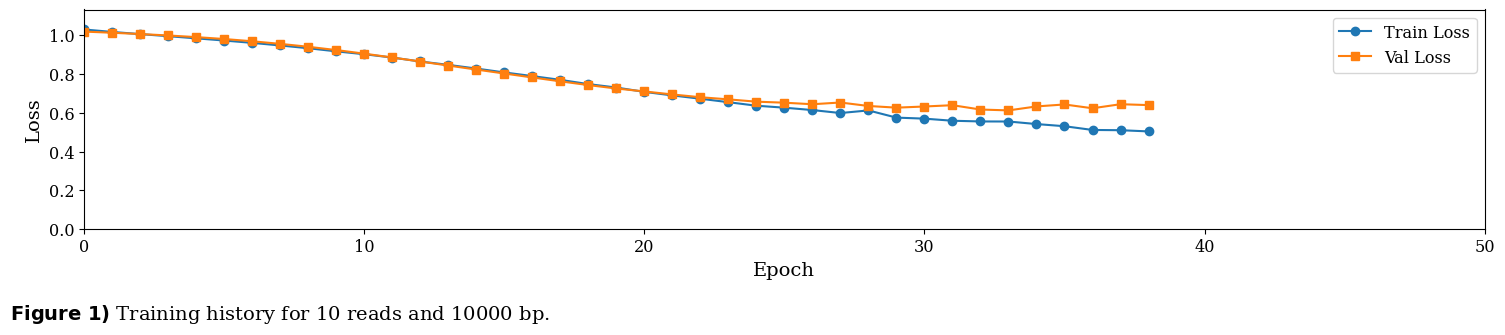

In [11]:
plt.figure(figsize=(15, 3))
plt.plot(train_losses, label="Train Loss", marker="o")
plt.plot(val_losses, label="Val Loss", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.ylim(0, max(max(train_losses), max(val_losses)) * 1.1)
plt.xlim(0, 50)
plt.tight_layout()
plotter.add_caption(
    f"Training history for {simulation_params.n_samples} reads and {simulation_params.length_bp} bp."
)

## Step 8: Evaluate on Test Set

In [ ]:
# Load best model
model.load_state_dict(torch.load(filename))

# Evaluate on test set
model.eval()
# test_loss, test_preds, test_labels = validate(model, test_loader, criterion, device)
test_loss, test_preds, test_labels = validate(
    model, test_loader, criterion_weighted, device
)

print(f"Test Loss: {test_loss:.4f}")

# Compute metrics
all_preds_flat = np.concatenate(test_preds).ravel()
all_labels_flat = np.concatenate(test_labels).ravel()

# Remove padding positions
valid_mask = all_labels_flat >= 0
all_preds_flat = all_preds_flat[valid_mask]
all_labels_flat = all_labels_flat[valid_mask]

# Threshold at 0.3 (lower for imbalanced data with weighted loss)
predictions_binary = (all_preds_flat >= 0.3).astype(int)


# Metrics: try sklearn, fallback to numpy implementations if missing
try:
    from sklearn.metrics import (
        accuracy_score,
        precision_score,
        recall_score,
        f1_score,
        roc_auc_score,
    )

    sklearn_available = True
except Exception as e:
    sklearn_available = False
    import warnings

    warnings.warn(
        "scikit-learn not installed; using numpy fallback for basic metrics. Install with: pip install scikit-learn"
    )

    def accuracy_score(y_true, y_pred):
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        return float((y_true == y_pred).mean())

    def precision_score(y_true, y_pred, zero_division=0):
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        tp = int(((y_true == 1) & (y_pred == 1)).sum())
        fp = int(((y_true == 0) & (y_pred == 1)).sum())
        denom = tp + fp
        if denom == 0:
            return float(zero_division)
        return float(tp / denom)

    def recall_score(y_true, y_pred, zero_division=0):
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        tp = int(((y_true == 1) & (y_pred == 1)).sum())
        fn = int(((y_true == 1) & (y_pred == 0)).sum())
        denom = tp + fn
        if denom == 0:
            return float(zero_division)
        return float(tp / denom)

    def f1_score(y_true, y_pred, zero_division=0):
        p = precision_score(y_true, y_pred, zero_division)
        r = recall_score(y_true, y_pred, zero_division)
        if (p + r) == 0:
            return float(zero_division)
        return 2 * (p * r) / (p + r)

    def roc_auc_score(y_true, y_score):
        y_true = np.asarray(y_true)
        y_score = np.asarray(y_score)
        # require both classes present
        if len(np.unique(y_true)) < 2:
            return float("nan")
        # Sort scores descending
        desc = np.argsort(-y_score)
        y_true_sorted = y_true[desc]
        # cumulative true/false positives
        tp = np.cumsum(y_true_sorted == 1)
        fp = np.cumsum(y_true_sorted == 0)
        tp_total = tp[-1]
        fp_total = fp[-1]
        if tp_total == 0 or fp_total == 0:
            return float("nan")
        tpr = np.concatenate([[0.0], tp / tp_total])
        fpr = np.concatenate([[0.0], fp / fp_total])
        return float(np.trapz(tpr, fpr))


# Calculate metrics
acc = accuracy_score(all_labels_flat, predictions_binary)
prec = precision_score(all_labels_flat, predictions_binary, zero_division=0)
rec = recall_score(all_labels_flat, predictions_binary, zero_division=0)
f1 = f1_score(all_labels_flat, predictions_binary, zero_division=0)
auc = roc_auc_score(all_labels_flat, all_preds_flat)

print(f"\nTest Metrics:")
print(f"  Accuracy:  {acc:.4f}")
print(f"  Precision: {prec:.4f}")
print(f"  Recall:    {rec:.4f}")
print(f"  F1-Score:  {f1:.4f}")
print(f"  ROC-AUC:   {auc:.4f}")

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

## Step 9: Save Model for Later Use

In [ ]:
# Save model and configuration
model_config = {
    "_vocab_size": 8,
    "_embedding_dim": 16,
    "_hidden_dim": 64,
    "_num_layers": 2,
    "_dropout": 0.3,
}

# Unified config file with two sections: 'simulation' and 'llm'
config_path = Path(filename).with_suffix(".json")
if config_path.exists():
    with open(config_path, "r") as f:
        existing_config = json.load(f)
else:
    existing_config = {}

# Preserve any existing sections; update/add the LLM section
existing_config["llm"] = model_config

with open(config_path, "w") as f:
    json.dump(existing_config, f, indent=4)

print("Model and config saved!")
print(f"Config path: {config_path}")
print(f"Config sections: {list(existing_config.keys())}")

## Step 10: Load Saved Model

In [ ]:
def predict_dyads(model, encoded_sequence, threshold=0.2, device="cpu"):
    """
    Predict dyad positions for a single sequence.

    Args:
        model: trained DyadPredictor
        encoded_sequence: list/array of integers (0-7)
        threshold: probability threshold for positive class (default 0.5)
        device: torch device

    Returns:
        dyad_positions: list of predicted dyad positions
        probabilities: array of per-position probabilities
    """

    model.eval()
    with torch.no_grad():
        seq_tensor = torch.LongTensor(encoded_sequence).unsqueeze(0).to(device)
        logits = model(seq_tensor)
        probs = torch.sigmoid(logits).squeeze().cpu().numpy()

    dyad_positions = np.where(probs >= threshold)[0].tolist()
    return dyad_positions, probs


# Load config (two-section format: {'simulation': {...}, 'llm': {...}})
with open(Path(filename).with_suffix(".json"), "r") as f:
    config = json.load(f)

llm_cfg = config.get("llm", {})

# Create model from LLM section (keys are prefixed with '_')
loaded_model = DyadPredictor(
    **{k[1:]: v for k, v in llm_cfg.items() if k.startswith("_")}
)
loaded_model.load_state_dict(torch.load(filename))
loaded_model = loaded_model.to(device)
loaded_model.eval()

# Use for predictions
new_seq = [1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4]

dyad_positions, _, encoded_seq = simulate_chromatin_fibers(n_samples=1, length=n_bp)

new_data = [(dyad_positions[0], encoded_seq[0])]
new_seq = new_data[0][1]

dyads, probs = predict_dyads(loaded_model, new_seq, device=device)

index = np.arange(len(new_seq))
nucs = np.zeros_like(index)
nucs[new_data[0][0]] = 1.0

for i in new_data[0][0]:
    nucs[i - 65 : i + 65] = -1  # highlight nucleosome region

n_plots = 10
for i in range(n_plots):
    plt.figure(figsize=(12, 1))
    plt.xlabel("i (bp)")

    plt.vlines(
        new_data[0][0], ymin=-1, ymax=2, color="black", linestyles="dotted", alpha=1
    )
    plt.fill_between(
        index, probs, label="Predicted Dyad Probability", color="orange", alpha=0.5
    )
    plt.fill_between(index, nucs, color="blue", alpha=0.5, label="True Dyad Positions")

    methylations = np.zeros_like(index) - 1
    methylations[index[new_seq > 4]] = 1
    plt.plot(
        index,
        methylations,
        "o",
        label="methylations",
        color="green",
        alpha=0.5,
        fillstyle="full",
        markersize=3,
    )

    plt.xlim(i * len(index) // n_plots, (i + 1) * len(index) // n_plots)
    plt.ylabel("Probability")
    plt.ylim(-0.1, 1.1)

    # plt.tight_layout
    plt.show()